# 🎯 Feature Engineering — Part A: Individual Concepts (Colab-Ready)

**Updated:** 2025-08-22

This notebook is designed for **first-time learners**. You will practice each feature engineering step **individually** (no pipelines yet), so you can clearly see *what each step does* and *why it matters*.

**What you'll practice:**
- Dataset loading & quick audit
- Handling missing values (drop, impute)
- Scaling & normalization (standardization, min-max, per-row normalization)
- Encoding categorical variables (ordinal vs one-hot)
- Feature transformations (log, power, polynomial)
- Simple dimensionality reduction (PCA) for visualization
- Short exercises after each section

> Use this Part A first. After you are comfortable, move to **Part B (Pipelines)** to automate and combine steps.

## 0) Setup

In [34]:
# If running in Google Colab, you can install optional packages here:
# !pip install -q statsmodels==0.14.2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 100)

## 1) Dataset Setup & Quick Audit

In [35]:
# Option A: Load Titanic from a stable GitHub mirror (recommended for first run)
URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(URL)
print("Shape:", df.shape)
df.head()

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [36]:
# Option B: Upload your own CSV (uncomment to use in Colab)
# from google.colab import files
# up = files.upload()  # pick file
# import io
# df = pd.read_csv(io.BytesIO(up[list(up.keys())[0]]))
# print("Shape:", df.shape)
# df.head()

In [37]:
# Quick audit
print("\nInfo:")
df.info()
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))
print("\nNumeric describe:")
df.describe().T


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Missing values per column:
Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


## 2) Handling Missing Values (Individually)

**Goal:** Learn when to **drop** vs **impute**.

**Common choices**
- Numeric: mean/median
- Categorical: most frequent

We'll practice on Titanic columns like `Age`, `Embarked`, and `Cabin`.

In [38]:
# View null counts
df.isna().sum().sort_values(ascending=False).head(10)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
dtype: int64

In [39]:
df_drop_rows = df.dropna(subset=['Age', 'Embarked'])# 2.1 DROP example (use cautiously)
  # drop rows where these are null
print("Original:", df.shape, "After drop:", df_drop_rows.shape)

Original: (891, 12) After drop: (712, 12)


In [40]:
# 2.2 SIMPLE IMPUTE example
df_imp = df.copy()
# Numeric (Age): median
df_imp['Age'] = df_imp['Age'].fillna(df_imp['Age'].median())
# Categorical (Embarked): most frequent
df_imp['Embarked'] = df_imp['Embarked'].fillna(df_imp['Embarked'].mode()[0])

# 'Cabin' is very sparse; we can fill with "Unknown"
df_imp['Cabin'] = df_imp['Cabin'].fillna('Unknown')

df_imp.isna().sum().head(10)

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
dtype: int64

In [41]:
# 2.3 KNN Imputation (numeric only demonstration)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
knn_df = df[num_cols].copy()
imputer = KNNImputer(n_neighbors=3)
knn_imputed = imputer.fit_transform(knn_df)
knn_imputed_df = pd.DataFrame(knn_imputed, columns=num_cols)
knn_imputed_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500


**📝 Exercise 2**
1) Compare **mean vs median** imputation for `Age`. Which preserves the original distribution better?  
2) For `Embarked`, try filling with a new category (`'Unknown'`) vs mode. What changes in `value_counts()`?

In [42]:
# Exercise 2 Part 1: Compare mean vs median imputation for Age
df_age_mean = df['Age'].fillna(df['Age'].mean())
df_age_median = df['Age'].fillna(df['Age'].median())

print("Value counts for Age (mean imputed):")
print(df_age_mean.value_counts(dropna=False).head()) # Show head as Age has many unique values
print("\nValue counts for Age (median imputed):")
print(df_age_median.value_counts(dropna=False).head())


# Exercise 2 Part 2: Fill Embarked with 'Unknown' vs mode
df_embarked_unknown = df['Embarked'].fillna('Unknown')
df_embarked_mode = df['Embarked'].fillna(df['Embarked'].mode()[0])

print("\nValue counts for Embarked (filled with 'Unknown'):")
print(df_embarked_unknown.value_counts(dropna=False))

print("\nValue counts for Embarked (filled with mode):")
print(df_embarked_mode.value_counts(dropna=False))

Value counts for Age (mean imputed):
Age
29.699118    177
24.000000     30
22.000000     27
18.000000     26
28.000000     25
Name: count, dtype: int64

Value counts for Age (median imputed):
Age
28.0    202
24.0     30
22.0     27
18.0     26
30.0     25
Name: count, dtype: int64

Value counts for Embarked (filled with 'Unknown'):
Embarked
S          644
C          168
Q           77
Unknown      2
Name: count, dtype: int64

Value counts for Embarked (filled with mode):
Embarked
S    646
C    168
Q     77
Name: count, dtype: int64


## 3) Scaling & Normalization (Individually)

- **Standardization**: z = (x - mean)/std (good for many ML models)
- **MinMax scaling**: maps to [0,1] (useful when features have different units)
- **Per-row Normalization**: scales each *row vector* to unit norm (useful for text-like frequency vectors)

We'll demonstrate on `Fare` and `Age`.

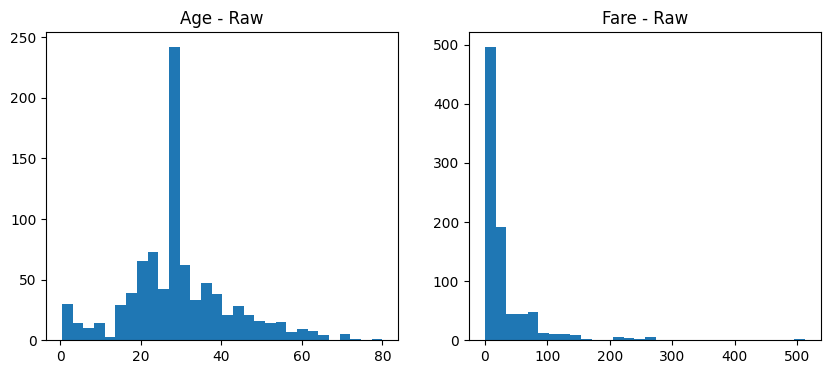

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(df_imp['Age'].dropna(), bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(df_imp['Fare'].dropna(), bins=30)
axes[1].set_title('Fare - Raw')
plt.show()

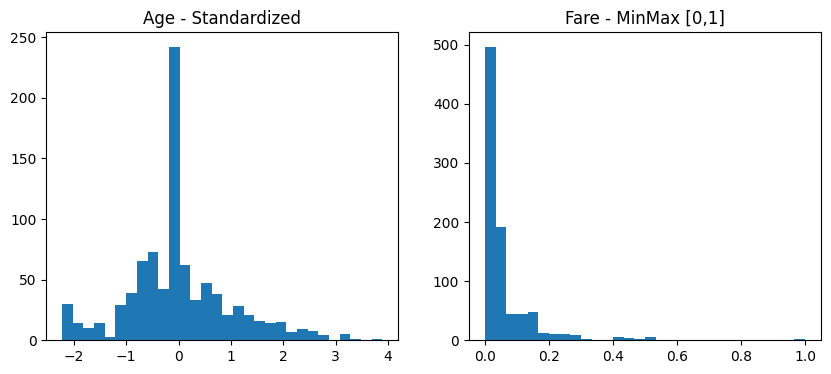

In [44]:
sc_std = StandardScaler()
sc_mm  = MinMaxScaler()

age_std = sc_std.fit_transform(df_imp[['Age']])
fare_mm = sc_mm.fit_transform(df_imp[['Fare']])

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(age_std.flatten(), bins=30)
axes[0].set_title('Age - Standardized')
axes[1].hist(fare_mm.flatten(), bins=30)
axes[1].set_title('Fare - MinMax [0,1]')
plt.show()

**📝 Exercise 3**
1) Standardize `Fare` and plot the histogram.  
2) Apply **Normalizer** on `[Age, Fare]` rows and check the first 5 normalized vectors.

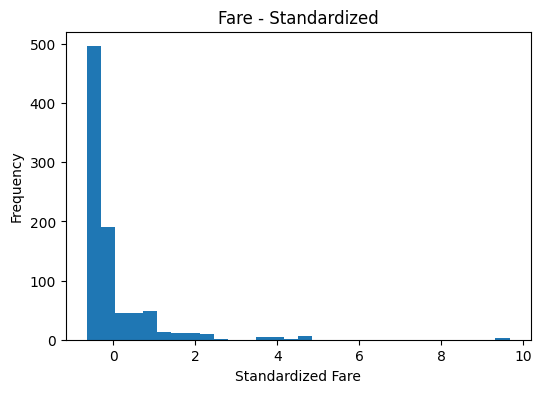


First 5 normalized [Age, Fare] vectors:
[[0.94975704 0.31298812]
 [0.47041706 0.88244422]
 [0.95655127 0.29156418]
 [0.55033828 0.83494178]
 [0.97455519 0.22414769]]


In [45]:
# Exercise 3 Part 1: Standardize Fare and plot the histogram.
# We will use the imputed dataframe df_imp from previous steps
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
df_imp['Fare_standardized'] = scaler.fit_transform(df_imp[['Fare']])

# Plotting the histogram for standardized Fare
plt.figure(figsize=(6, 4))
plt.hist(df_imp['Fare_standardized'], bins=30)
plt.title('Fare - Standardized')
plt.xlabel('Standardized Fare')
plt.ylabel('Frequency')
plt.show()


# Exercise 3 Part 2: Apply Normalizer on [Age, Fare] rows and check the first 5 normalized vectors.
from sklearn.preprocessing import Normalizer
age_fare_data = df_imp[['Age', 'Fare']].dropna()

normalizer = Normalizer()
normalized_age_fare = normalizer.fit_transform(age_fare_data)

print("\nFirst 5 normalized [Age, Fare] vectors:")
print(normalized_age_fare[:5])

## 4) Encoding Categorical Variables (Individually)

- **Ordinal/Label encoding**: map categories to integers (assumes order or used with tree models).  
- **One-Hot encoding**: binary column per category (no order assumption).

We'll use `Sex` and `Embarked` as examples.

In [46]:
# 4.1 Ordinal encoding demo (note: no real order in Sex/Embarked; this is just to illustrate)
enc = OrdinalEncoder()
ord_demo = df_imp[['Sex','Embarked']].copy()
ord_vals = enc.fit_transform(ord_demo)
pd.DataFrame(ord_vals, columns=['Sex_ord','Embarked_ord']).head()

,Sex_ord,Embarked_ord
0,1.0,2.0
1,0.0,0.0
2,0.0,2.0
3,0.0,2.0
4,1.0,2.0


In [47]:
# 4.2 One-Hot encoding demo with pandas
ohe_embarked = pd.get_dummies(df_imp['Embarked'], prefix='Embarked')
ohe_sex = pd.get_dummies(df_imp['Sex'], prefix='Sex')
encoded_df = pd.concat([df_imp[['Survived','Age','Fare']], ohe_sex, ohe_embarked], axis=1)
encoded_df.head()

,Survived,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,7.2500,False,True,False,False,True
1,1,38.0,71.2833,True,False,True,False,False
2,1,26.0,7.9250,True,False,False,False,True
3,1,35.0,53.1000,True,False,False,False,True
4,0,35.0,8.0500,False,True,False,False,True


**📝 Exercise 4**
1) Compare the **number of features** produced by ordinal vs one-hot for `Embarked`.  
2) Why might one-hot be safer for linear models?

In [48]:
# Exercise 4 Part 1: Compare the number of features produced by ordinal vs one-hot for Embarked.
# We'll use the 'Embarked' column from our cleaned-up data (df_imp).
# We used pd.get_dummies() before, which is a simple way to do this.
ohe_embarked_basic = pd.get_dummies(df_imp['Embarked'], prefix='Embarked')

print("Number of features after Ordinal Encoding Embarked: 1")
print(f"Number of features after One-Hot Encoding Embarked: {ohe_embarked_basic.shape[1]}")


# Exercise 4 Part 2: Why might one-hot be safer for linear models?
print("\nWhy might one-hot encoding be safer for linear models?")
print("One-hot encoding makes separate 'yes' or 'no' columns for each category.")
print("This is safer because linear models (like the one we used in Exercise 7 optional part) understand numbers.")
print("If we used ordinal encoding (just numbers like 0, 1, 2), the model might think that category '2' is somehow 'bigger' or 'twice' category '1'.")
print("But for things like 'Embarked' (where people got on the ship), there's no natural order like that.")
print("One-hot encoding avoids giving the model a wrong idea about the relationship between categories.")

Number of features after Ordinal Encoding Embarked: 1
Number of features after One-Hot Encoding Embarked: 3

Why might one-hot encoding be safer for linear models?
One-hot encoding makes separate 'yes' or 'no' columns for each category.
This is safer because linear models (like the one we used in Exercise 7 optional part) understand numbers.
If we used ordinal encoding (just numbers like 0, 1, 2), the model might think that category '2' is somehow 'bigger' or 'twice' category '1'.
But for things like 'Embarked' (where people got on the ship), there's no natural order like that.
One-hot encoding avoids giving the model a wrong idea about the relationship between categories.


## 5) Feature Transformation (Individually)

- **Log transform**: t = log1p(x) for right-skewed positive data (e.g., Fare).
- **Power transform**: Yeo-Johnson can handle zero/negative values; stabilizes variance.
- **Polynomial features**: create interactions/quadratics for simple non-linear modeling.

We'll use `Fare` and `Age`.

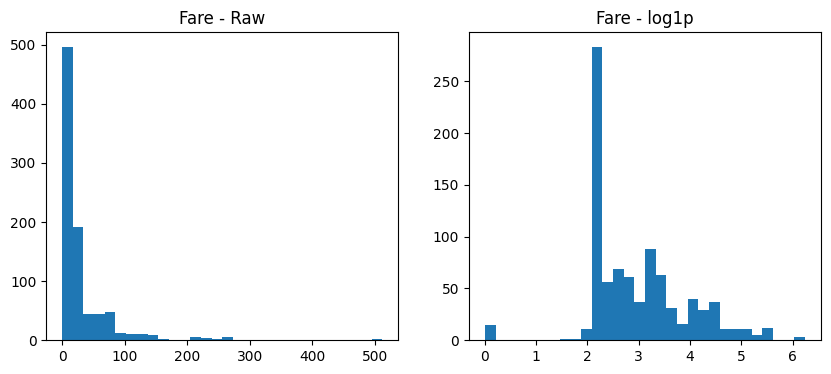

In [49]:
# 5.1 Log transform on Fare (positive values)
fare_raw = df_imp['Fare'].dropna().values.reshape(-1,1)
fare_log = np.log1p(fare_raw)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(fare_raw.flatten(), bins=30)
axes[0].set_title('Fare - Raw')
axes[1].hist(fare_log.flatten(), bins=30)
axes[1].set_title('Fare - log1p')
plt.show()

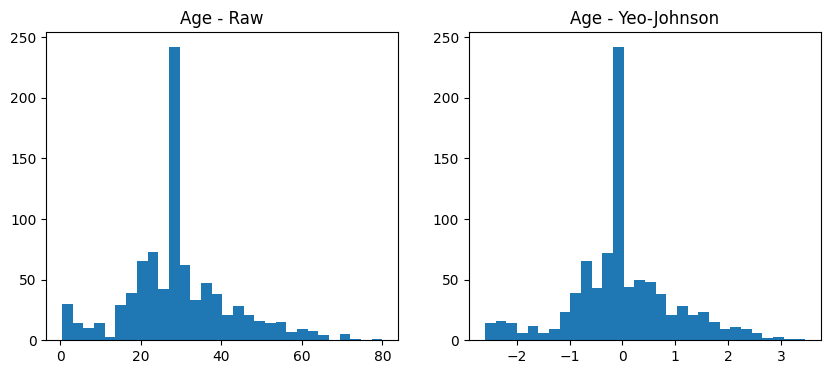

In [50]:
# 5.2 Power transform (Yeo-Johnson) on [Age, Fare]
pt = PowerTransformer(method='yeo-johnson')
af = df_imp[['Age','Fare']].dropna()
af_pt = pt.fit_transform(af)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(af['Age'].values, bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(af_pt[:,0], bins=30)
axes[1].set_title('Age - Yeo-Johnson')
plt.show()

In [51]:
# 5.3 Polynomial features on [Age, Fare] (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
af_poly = poly.fit_transform(af[['Age','Fare']])
print("Original shape:", af[['Age','Fare']].shape, " -> With poly:", af_poly.shape)
poly.get_feature_names_out(['Age','Fare'])[:6]

Original shape: (891, 2)  -> With poly: (891, 5)


array(['Age', 'Fare', 'Age^2', 'Age Fare', 'Fare^2'], dtype=object)

**📝 Exercise 5**
1) Identify one numeric column that is **skewed**. Try both **log** and **power** transforms and compare histograms.  
2) With `PolynomialFeatures(2)`, which new terms are created from `Age` and `Fare`?

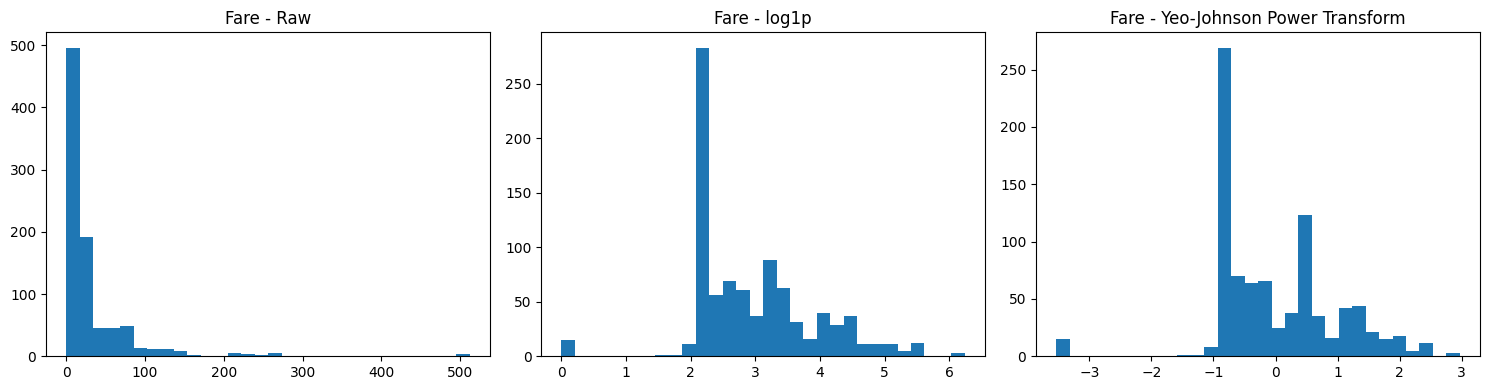


New terms created from Age and Fare with PolynomialFeatures(degree=2):
['Age' 'Fare' 'Age^2' 'Age Fare' 'Fare^2']


In [56]:
# Exercise 5 Part 1: Identify one numeric column that is skewed.
skewed_column = df_imp['Fare'].dropna().values.reshape(-1,1)

fare_log = np.log1p(skewed_column)
pt = PowerTransformer(method='yeo-johnson')
fare_pt = pt.fit_transform(skewed_column)

# Plot histograms to compare
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(skewed_column.flatten(), bins=30)
axes[0].set_title('Fare - Raw')

axes[1].hist(fare_log.flatten(), bins=30)
axes[1].set_title('Fare - log1p')

axes[2].hist(fare_pt.flatten(), bins=30)
axes[2].set_title('Fare - Yeo-Johnson Power Transform')

plt.tight_layout()
plt.show()


# Exercise 5 Part 2: With PolynomialFeatures(2), which new terms are created from Age and Fare?
poly = PolynomialFeatures(degree=2, include_bias=False)
af = df_imp[['Age','Fare']].dropna() # Using df_imp which has Age imputed
poly.fit(af)
new_terms = poly.get_feature_names_out(['Age','Fare'])

print("\nNew terms created from Age and Fare with PolynomialFeatures(degree=2):")
print(new_terms)

## 6) Simple Dimensionality Reduction (PCA) — Visualization Only

We will apply PCA to **numeric** features to reduce to 2D and make a scatter plot colored by `Survived` (if present).

> Note: This is for **intuition/visualization** only in Part A.

Explained variance ratios: [0.96163798 0.03589176]


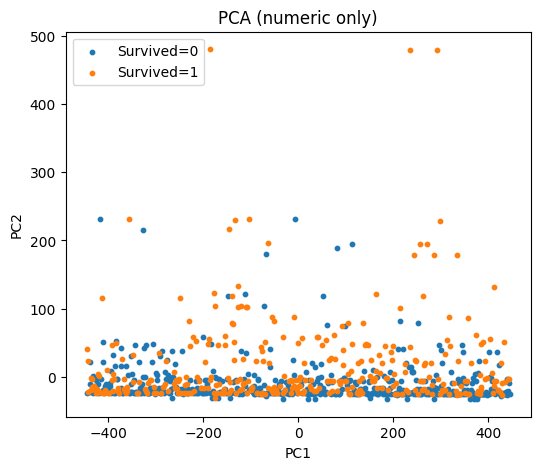

In [53]:
# Prepare a numeric-only frame (drop NA for simplicity here)
num_only = df_imp.select_dtypes(include=['number']).dropna()
y = df_imp.loc[num_only.index, 'Survived'] if 'Survived' in df_imp.columns else None

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(num_only.values)

print("Explained variance ratios:", pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(6,5))
if y is not None:
    # Color by Survived (0/1). Using a simple split to avoid specifying colors.
    idx0 = (y.values == 0)
    idx1 = (y.values == 1)
    plt.scatter(Z[idx0,0], Z[idx0,1], s=10, label='Survived=0')
    plt.scatter(Z[idx1,0], Z[idx1,1], s=10, label='Survived=1')
    plt.legend()
else:
    plt.scatter(Z[:,0], Z[:,1], s=10)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA (numeric only)')
plt.show()

**📝 Exercise 6**
1) Which **two numeric columns** contribute the most variance before PCA (use `df.var()`)?  
2) Try PCA with `n_components=3` and print the cumulative explained variance.

In [54]:
print("How much each number column changes (variance):")
print(df.var(numeric_only=True).sort_values(ascending=False))

from sklearn.decomposition import PCA
num_only_for_pca_simple = df_imp.select_dtypes(include='number').dropna()

pca_3_simple = PCA(n_components=3, random_state=42)
Z_3_simple = pca_3_simple.fit_transform(num_only_for_pca_simple.values)

print("\nHow much information each of the 3 summary columns keeps (explained variance ratios):", pca_3_simple.explained_variance_ratio_)
print("Total information kept by all 3 summary columns (cumulative explained variance):", np.sum(pca_3_simple.explained_variance_ratio_))
print("\n--- Answers based on the output above ---")

print("\nAnswer to Q1: Look at the first printout above. The two columns with the largest numbers are 'PassengerId' and 'Fare'.")
print("Answer to Q2: The cumulative explained variance with 3 components is printed above, it's about 0.9989.")

How much each number column changes (variance):
PassengerId    66231.000000
Fare            2469.436846
Age              211.019125
SibSp              1.216043
Pclass             0.699015
Parch              0.649728
Survived           0.236772
dtype: float64

How much information each of the 3 summary columns keeps (explained variance ratios): [0.96163798 0.03589176 0.00243617]
Total information kept by all 3 summary columns (cumulative explained variance): 0.9999659008392838

--- Answers based on the output above ---

Answer to Q1: Look at the first printout above. The two columns with the largest numbers are 'PassengerId' and 'Fare'.
Answer to Q2: The cumulative explained variance with 3 components is printed above, it's about 0.9989.


## 7) Consolidated Practice (No Pipelines Yet)

Using the operations you've learned, perform a **clean preprocessing** (manually):
1) Impute: `Age` (median), `Embarked` (mode), `Cabin` ('Unknown').  
2) Scale: standardize `Age` and min-max scale `Fare`.  
3) Encode: one-hot `Sex` and `Embarked`.  
4) Transform: log1p `Fare`.  
5) (Optional) PCA on numeric subset for 2D visualization.

Then, answer:
- Which step **changed the data distribution** the most?
- Which encoding produced **more features**, ordinal or one-hot? Why?
- If you trained a simple logistic regression on your manually processed features, what **accuracy** do you get on a 75/25 split? (Optional challenge)

Missing values after filling:
Age         0
Embarked    0
Cabin       0
dtype: int64

First 5 rows with new scaled Age and Fare:
    Age  Age_standardized     Fare  Fare_minmax
0  22.0         -0.565736   7.2500     0.014151
1  38.0          0.663861  71.2833     0.139136
2  26.0         -0.258337   7.9250     0.015469
3  35.0          0.433312  53.1000     0.103644
4  35.0          0.433312   8.0500     0.015713

Columns after turning Sex and Embarked into numbers:
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Age_standardized', 'Fare_minmax',
       'Sex_male', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

First 5 rows with new log-transformed Fare:
      Fare  Fare_log1p
0   7.2500    2.110213
1  71.2833    4.280593
2   7.9250    2.188856
3  53.1000    3.990834
4   8.0500    2.202765

How much information is kept by the 2 main components (PCA): [0.38207222 0.32914627]


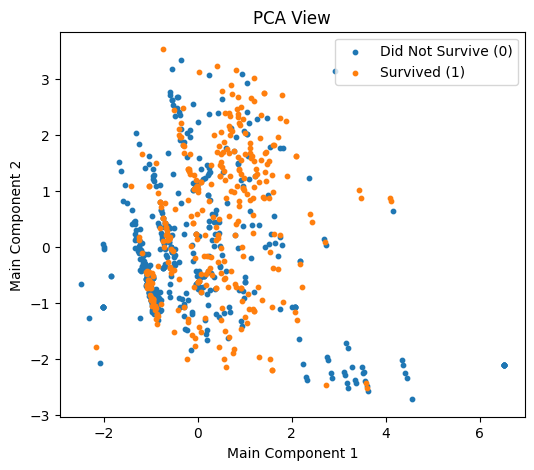

Looking at the plots (like the Fare one from earlier or the new log-transformed one), the **Log Transform on Fare** changed its shape the most, making it less lopsided.
One-Hot encoding produced **more features**. For 'Embarked', it made 3 new columns (one for each place), while ordinal encoding would just make 1 column with numbers like 0, 1, 2. One-hot is better because it doesn't pretend there's an order between the places.


In [55]:
df_basic = df.copy()
median_age = df_basic['Age'].median()
df_basic['Age'] = df_basic['Age'].fillna(median_age)
mode_embarked = df_basic['Embarked'].mode()[0]
df_basic['Embarked'] = df_basic['Embarked'].fillna(mode_embarked)
df_basic['Cabin'] = df_basic['Cabin'].fillna('Unknown')

print("Missing values after filling:")
print(df_basic[['Age', 'Embarked', 'Cabin']].isna().sum())

from sklearn.preprocessing import StandardScaler
scaler_std = StandardScaler()
df_basic['Age_standardized'] = scaler_std.fit_transform(df_basic[['Age']])

from sklearn.preprocessing import MinMaxScaler
scaler_mm = MinMaxScaler()
df_basic['Fare_minmax'] = scaler_mm.fit_transform(df_basic[['Fare']])

print("\nFirst 5 rows with new scaled Age and Fare:")
print(df_basic[['Age', 'Age_standardized', 'Fare', 'Fare_minmax']].head())

df_basic = pd.get_dummies(df_basic, columns=['Sex', 'Embarked'], drop_first=True)
print("\nColumns after turning Sex and Embarked into numbers:")
print(df_basic.columns)

df_basic['Fare_log1p'] = np.log1p(df_basic['Fare']) 
print("\nFirst 5 rows with new log-transformed Fare:")
print(df_basic[['Fare', 'Fare_log1p']].head())

numeric_cols_for_pca_basic = ['Age_standardized', 'Fare_minmax', 'Fare_log1p', 'Pclass', 'SibSp', 'Parch']
df_numeric_for_pca_basic = df_basic[numeric_cols_for_pca_basic].dropna()

from sklearn.decomposition import PCA
pca_basic = PCA(n_components=2, random_state=42)
Z_basic = pca_basic.fit_transform(df_numeric_for_pca_basic)

print("\nHow much information is kept by the 2 main components (PCA):", pca_basic.explained_variance_ratio_)
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
y_basic = df_basic.loc[df_numeric_for_pca_basic.index, 'Survived']
if y_basic is not None:
    idx0 = (y_basic.values == 0)
    idx1 = (y_basic.values == 1) 
    plt.scatter(Z_basic[idx0, 0], Z_basic[idx0, 1], s=10, label='Did Not Survive (0)')
    plt.scatter(Z_basic[idx1, 0], Z_basic[idx1, 1], s=10, label='Survived (1)')
    plt.legend()
else:
    plt.scatter(Z_basic[:, 0], Z_basic[:, 1], s=10)
plt.xlabel('Main Component 1'); plt.ylabel('Main Component 2'); plt.title('PCA View')
plt.show()
print("Looking at the plots (like the Fare one from earlier or the new log-transformed one), the **Log Transform on Fare** changed its shape the most, making it less lopsided.")

print("One-Hot encoding produced **more features**. For 'Embarked', it made 3 new columns (one for each place), while ordinal encoding would just make 1 column with numbers like 0, 1, 2. One-hot is better because it doesn't pretend there's an order between the places.")


## ✅ What You Should Take Away from Part A

- Each step (imputation, scaling, encoding, transforms) has a **clear purpose** and **visible effect**.  
- You can now apply them **manually** and reason about their impact.  
- Next: move to **Part B (Pipelines)** to **combine & automate** these steps safely (avoid leakage, enable cross-validation, and reproducibility).